In [2]:
! pip uninstall tensorflow
! pip install tensorflow --upgrade

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 3.8MB 37.2MB/s 
     |████████████████████████████████| 450kB 40.5MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 w

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# table of contents

# 1. PCA on images for visualization
# 2. PCA on images for compression
# 3. PCA on images in a simple classificaiton
# 4. Grid search cross validation for hyperparameters in three ML classifiers

In [0]:
# imports
import numpy as np
import pylab as py
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, metrics
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from warnings import simplefilter
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression

%matplotlib inline

# functions
def plot_gallery(data, labels, shape, interpolation='nearest'):
    py.figure(figsize=(15, 15))
    for i in range(data.shape[0]):
        py.subplot(1, data.shape[0], (i + 1))
        py.imshow(data[i].reshape(shape), interpolation=interpolation)
        py.title(labels[i])
        py.xticks(()), py.yticks(())
        py.gray()

# global variables
fashion_mnist = keras.datasets.fashion_mnist
class_names = ['T-Shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
(train_i, train_l), (test_i, test_l) = fashion_mnist.load_data()
i_shape = (28, 28)
split_size = 0.4

In [4]:
# image recognition setup

train_i = train_i.reshape((train_i.shape[0], train_i.shape[1] * train_i.shape[2]))
test_i = test_i.reshape((test_i.shape[0], test_i.shape[1] * test_i.shape[2]))

print("training data shape:   %r\ntraining target shape: %r"%(train_i.shape, train_l.shape))
print("training classes:      %r"%(list(np.unique(train_l))))
print("testing data shape:    %r\ntesting target shape:  %r"%(test_i.shape, test_l.shape))
print("testing classes:       %r"%(list(np.unique(test_l))))

n_samples, n_features = train_i.shape
split_size = 1 - 1000/n_samples
print("n_samples:  %d" % n_samples)
print("n_features: %d" % n_features)

training data shape:   (60000, 784)
training target shape: (60000,)
training classes:      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
testing data shape:    (10000, 784)
testing target shape:  (10000,)
testing classes:       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_samples:  60000
n_features: 784


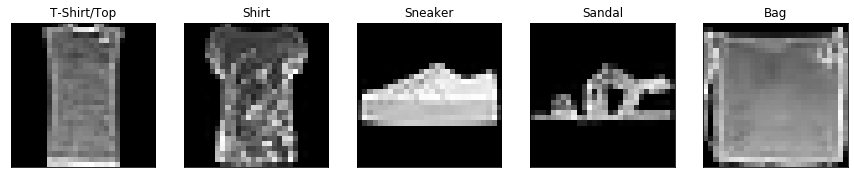

In [5]:
subsample = np.random.permutation(train_i.shape[0])[:5]
images = train_i[subsample]
labels = [class_names[l] for l in train_l[subsample]]
plot_gallery(images, labels, shape=i_shape)

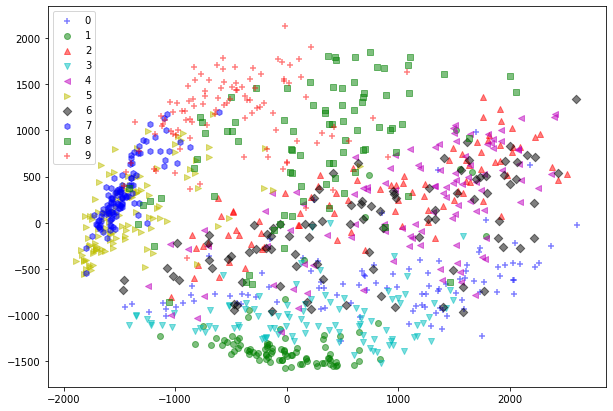

In [17]:
# 1. PCA on digits for visualization

pca = PCA(n_components=5)
train_i_pca = pca.fit_transform(train_i)

train_i_pca.shape

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
markers = ['+', 'o', '^', 'v', '<', '>', 'D', 'h', 's']
py.figure(figsize=(10, 7))
for i, c, m in zip(np.unique(train_l[0:1000]), cycle(colors), cycle(markers)):
    py.scatter(train_i_pca[train_l == i, 0], train_i_pca[train_l == i, 1],
        c=c, marker=m, label=i, alpha=0.5)

_ = py.legend(loc='best')

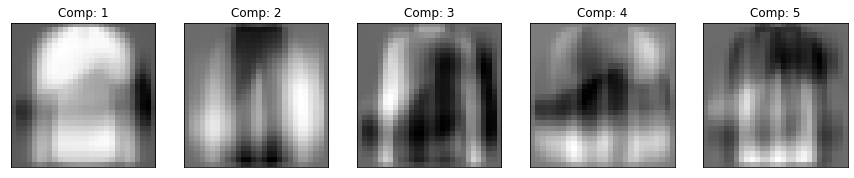

In [7]:
labels = ['Comp: %d' % (i+1) for i in range(len(pca.components_)) ]
plot_gallery(pca.components_, labels, shape=i_shape)

I expect classes where the articles of clothing are shaped similarly to be near each other on the plot (e.g. t-shirts/pullovers/coats). This is more for the overall shape, as opposed to some of the smaller characteristics.

compressed images of first 5 digits
with this many PCA components: [1, 2, 3, 5, 10, 20, 40, 80, 160, 784]
number of dimensions:  1
number of dimensions:  2
number of dimensions:  3
number of dimensions:  5
number of dimensions:  10
number of dimensions:  20
number of dimensions:  40
number of dimensions:  80
number of dimensions:  160
number of dimensions:  784


<Figure size 432x288 with 0 Axes>

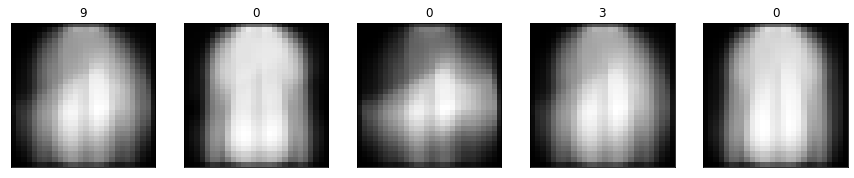

<Figure size 432x288 with 0 Axes>

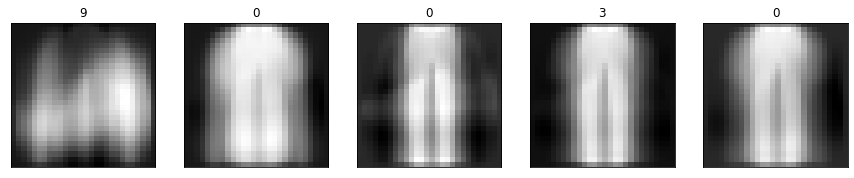

<Figure size 432x288 with 0 Axes>

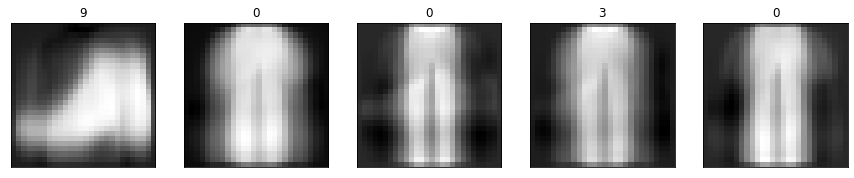

<Figure size 432x288 with 0 Axes>

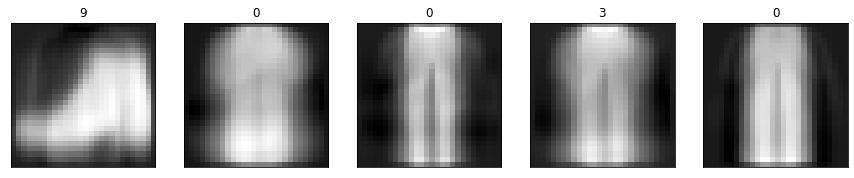

<Figure size 432x288 with 0 Axes>

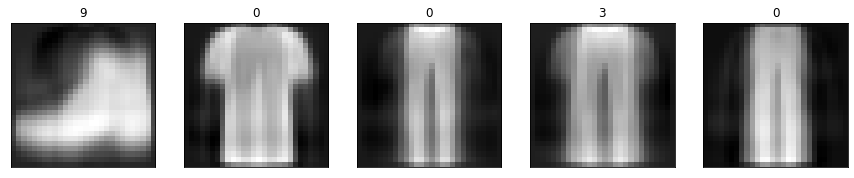

<Figure size 432x288 with 0 Axes>

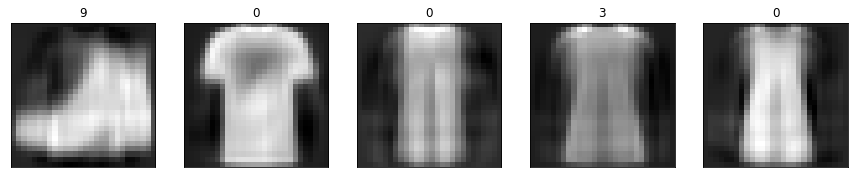

<Figure size 432x288 with 0 Axes>

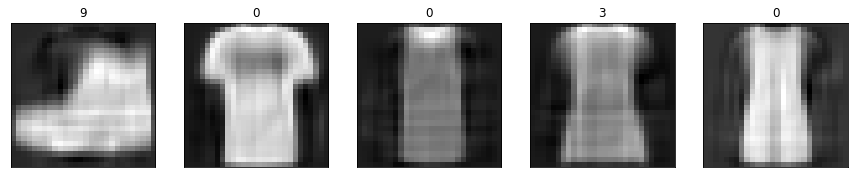

<Figure size 432x288 with 0 Axes>

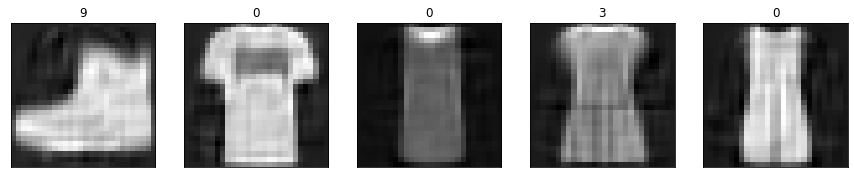

<Figure size 432x288 with 0 Axes>

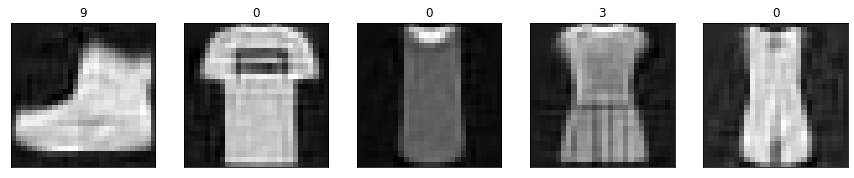

<Figure size 432x288 with 0 Axes>

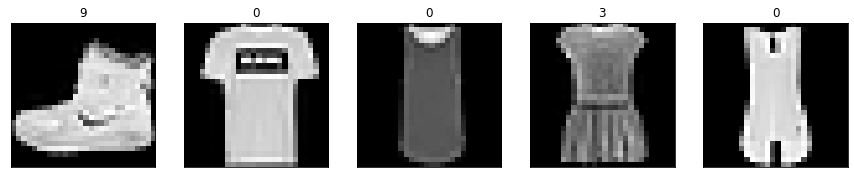

In [8]:
# 2. PCA on digits for compression

n = 5 # number of digits for demonstration
dims = [1, 2, 3, 5, 10, 20, 40, 80, 160, 784]
print('compressed images of first', n, 'digits')
print('with this many PCA components:', dims)
for d in dims:  # dimensionality for compressed signal
    print('number of dimensions: ', d)
    pca = PCA(n_components=d)
    pca.fit_transform(train_i)
    reduced_train_i = pca.transform(train_i[0:n]) # the reduced dimensionality
    recovered_train_i = pca.inverse_transform(reduced_train_i)
    py.figure()
    plot_gallery(recovered_train_i, train_l[0:n], shape=i_shape)

At 20 components, much of the shape between similar classes (such as shirts and dresses) becomes visible. At 80 components, most of the detail has been captured.

In [9]:
# 3. PCA on digits improve classification

train_i_pca, test_i_dump, train_l_pca, test_l_dump = train_test_split(train_i, train_l, test_size=split_size)
del test_i_dump
del test_l_dump

print("train data shape: %r, train target shape: %r"
      % (train_i_pca.shape, train_l_pca.shape))
print("test data shape: %r, test target shape: %r"
      % (train_i_pca.shape, train_l_pca.shape))

model = GaussianNB().fit(train_i_pca, train_l_pca)
train_score = model.score(train_i_pca, train_l_pca) 
print('training score (overfitting!):', train_score)

test_score = model.score(test_i, test_l)
print('test score:', test_score)

train data shape: (1000, 784), train target shape: (1000,)
test data shape: (1000, 784), test target shape: (1000,)
training score (overfitting!): 0.639
test score: 0.5342


In [10]:
# but now using PCA features instead of pixels directly!

pca = PCA(n_components=10)
pca.fit(train_i_pca)

train_i_trans = pca.transform(train_i_pca)
test_i_trans = pca.transform(test_i)

model = GaussianNB().fit(train_i_trans, train_l_pca)
train_score = model.score(train_i_trans, train_l_pca) 
print('training score (overfitting!):', train_score)

test_score = model.score(test_i_trans, test_l)
print('test score:', test_score)

test_l_preds = model.predict(test_i_trans)
expected = test_l
predicted = model.predict(test_i_trans)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

training score (overfitting!): 0.738
test score: 0.7033
Confusion matrix:
[[692   1  21  94  16  37 107   0  32   0]
 [  5 893   7  71  13   4   6   0   1   0]
 [  8   0 483   6 217  19 240   0  27   0]
 [ 40  15   5 766  59  15  94   0   6   0]
 [  0   1 219  41 578  12 136   0  13   0]
 [  0   0   0   2   0 722   7 157  24  88]
 [176   0 137  56 185  45 353   0  48   0]
 [  0   0   0   0   0 125   1 803   3  68]
 [  7   0  10  10  11  40  51  10 859   2]
 [  0   0   0   1   1  40   1  70   3 884]]


Text(0, 0.5, 'image recognition accuracy')

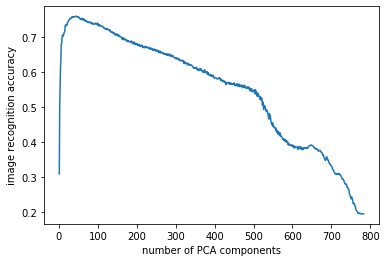

In [11]:
# let's plot accuracy vs number of components!

accuracy = []
n_comp = range(1, n_features)
for i in n_comp:
    pca = PCA(n_components=i)
    pca.fit(train_i_pca)

    train_i_trans = pca.transform(train_i_pca)
    test_i_trans = pca.transform(test_i)

    model = GaussianNB().fit(train_i_trans, train_l_pca)
    test_score = model.score(test_i_trans, test_l)
    accuracy.append(test_score)

py.plot(n_comp, accuracy)
py.xlabel('number of PCA components')
py.ylabel('image recognition accuracy')

In [0]:
#4. Grid search cross validation for hyperparameters in three ML classifiers
#   For each model grid search is used to generate set of hyperparameters to test
#   then cross validation is used to evaluate the hyperparemeters
#   the best model hyperparameters from cross validation are then used
#   to predict a hold-out test set

# Import datasets, classifiers and performance metrics
# import warnings filter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

fashion_mnist = keras.datasets.fashion_mnist
(train_i, train_l), (test_i, test_l) = fashion_mnist.load_data()
train_i = train_i.reshape((train_i.shape[0], train_i.shape[1]*train_i.shape[2]))
test_i = test_i.reshape((test_i.shape[0], test_i.shape[1]*test_i.shape[2]))

# CHANGE NUM OF COMPONENTS!
final = [[""]*4 for i in range(3)]
pca = PCA(n_components=64)
pca.fit(train_i)

train_i = pca.transform(train_i)
test_i = pca.transform(test_i)
train_i, test_i_dump, train_l, test_l_dump = train_test_split(train_i, train_l, test_size=split_size)
del test_i_dump
del test_l_dump

In [0]:
#k-NN
parameters = {'n_neighbors': list(range(1,10))}
knn = KNeighborsClassifier()
scores = cross_val_score(knn, train_i, train_l, cv=5)
default_train=np.mean(scores)

clf = GridSearchCV(knn, parameters, cv=5, scoring="accuracy", iid=False)
clf.fit(train_i, train_l)
best_train = clf.best_score_
nn = clf.best_estimator_.n_neighbors

trian_l_preds = clf.predict(test_i) # runs the model with the best score
best_test = metrics.accuracy_score(test_l, trian_l_preds)

final[0][0] = str(default_train)
final[0][1] = str(best_train)
final[0][2] = "n_neighbors: "+str(nn)
final[0][3] = str(best_test)

In [0]:
#Decision Tree
DT = tree.DecisionTreeClassifier()
scores = cross_val_score(DT, train_i, train_l, cv=5)
default_train = np.mean(scores)

parameters = {'min_samples_split': list(range(2, 10))}
clf = GridSearchCV(DT, parameters, cv=5, scoring="accuracy", iid=False)
clf.fit(train_i, train_l)
best_train = clf.best_score_
min_samples = clf.best_estimator_.min_samples_split

train_l_preds = clf.predict(test_i) # runs the model with the best score
best_test = metrics.accuracy_score(test_l, train_l_preds)

final[1][0] = str(default_train)
final[1][1] = str(best_train)
final[1][2] = "min_samples: "+str(min_samples)
final[1][3] = str(best_test)

In [0]:
#Logistic Regression
regression = LogisticRegression(penalty='l1', solver='saga', tol=0.01)
scores = cross_val_score(regression, train_i, train_l, cv=5)
default_train = np.mean(scores)

parameters = {'C': [10**(i-4) for i in range(9)]}
clf = GridSearchCV(regression, parameters, cv=5,scoring="accuracy",iid=False)
clf.fit(train_i, train_l)
best_train = clf.best_score_
C = clf.best_estimator_.C

train_l_pred = clf.predict(test_i) # runs the model with the best score
best_test = metrics.accuracy_score(test_l, train_l_pred)

final[2][0]=str(default_train)
final[2][1]=str(best_train)
final[2][2]="C: "+str(C)
final[2][3]=str(best_test)

In [16]:
left=["K-nearest neighbors: ","Decision Trees:      ","Logistic Regression: "]
print("Model                "," Default Accuracy","Tuned Valid. Acc.",
 " Hyperparameters ","  Test Set Acc. ",sep="|",end="|\n")
for i in range(50):
 print("_",end="_")
print("")
for i in range(3):
 print(left[i],end="|")
 for j in range(4):
   print('{:>17.15}'.format(final[i][j]),end="|")
 print("")

Model                | Default Accuracy|Tuned Valid. Acc.| Hyperparameters |  Test Set Acc. |
____________________________________________________________________________________________________
K-nearest neighbors: |            0.757|            0.772|   n_neighbors: 1|           0.7509|
Decision Trees:      |  0.6280000000000|            0.634|   min_samples: 7|           0.6368|
Logistic Regression: |  0.8049999999999|            0.808|             C: 1|           0.7847|
